TODO:
- Adjust fuzz ratio to catch all labels

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
import seaborn as sns
from tqdm import tqdm
from fuzzywuzzy import fuzz

train_example_paths = glob.glob('data/train/*.json')
test_example_paths = glob.glob('data/test/*.json')

train_example_names = [fn.split('.')[0] for fn in os.listdir('data/train')]
test_example_names = [fn.split('.')[0] for fn in os.listdir('data/test')]

metadata = pd.read_csv('data/train.csv')
metadata_train = metadata.loc[metadata.Id.isin(train_example_names)]
metadata_test = metadata.loc[metadata.Id.isin(test_example_names)]

metadata = pd.read_csv('data/train.csv')
metadata_train = metadata.loc[metadata.Id.isin(train_example_names)]
metadata_test = metadata.loc[metadata.Id.isin(test_example_names)]

In [2]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def get_doc_id(doc_path):
    return os.path.split(train_example_names[0])[-1].split('.')[0]

def load_train_example(i: int):
    doc_path = train_example_paths[i]
    with open(doc_path) as f:
        data = json.load(f)
    return {'doc': data, 'meta': metadata.loc[metadata.Id == get_doc_id(doc_path)]}

def load_train_example_by_name(name):
    doc_path = os.path.join('data/train', name + '.json')
    with open(doc_path) as f:
        data = json.load(f)
    return data

def delete_file(filename):
    if os.path.exists(filename):
        os.remove(filename)

## Split Data

In [3]:
import random

docIdx = train_example_names.copy()
random.seed(42)
random.shuffle(docIdx)

train_ratio = 0.8
n_train = int(len(docIdx) * train_ratio)
n_val = len(docIdx) - n_train

train_idx = docIdx[:n_train]
val_idx = docIdx[n_train:]

print(f'train size: {len(train_idx)}')
print(f'val size: {len(val_idx)}')

train size: 11452
val size: 2864


## Generate Dataset and Features

In [4]:
_RE_COMBINE_WHITESPACE = re.compile(r"\s+")

def preprocess_tokenize_doc(doc_json):
    doc_text = ' '.join([clean_text(sec['text']) for sec in doc_json])
    doc_text = make_single_whitespace(doc_text)

    doc_tokens = doc_text.split(' ')
    return doc_tokens

def indices(lst, element):
    result = [i for i, token in enumerate(lst) if element in token]
    return result

def make_single_whitespace(text):
    return _RE_COMBINE_WHITESPACE.sub(" ", text).strip()

## Create dataframe for tokens and targets

In [5]:
df_cols = ['TOKEN', 'TARGET']
doc_dfs = {}
n_examples = len(metadata_train)

for doc_id in tqdm(train_example_names):
    doc_df = pd.DataFrame(columns = df_cols)

    doc_labels = list(metadata_train.loc[metadata_train.Id == doc_id, 'cleaned_label'].values)

    doc = load_train_example_by_name(doc_id)
    doc_tokens = preprocess_tokenize_doc(doc)
    
    # Targets for dataset names will be 1
    target_arr = np.zeros(len(doc_tokens) ,dtype = 'uint8')

    # Keep 100 tokens before and after targets
    keep_df = pd.Series(np.zeros(len(doc_tokens), dtype = 'bool'))

    for l in doc_labels:
        label = l.strip()
        n_label_tokens = len(label.split(' '))
        doc_tokens_joined = [' '.join(doc_tokens[i:i+n_label_tokens]) for i in range(len(doc_tokens) - n_label_tokens + 1)]
        
        occurrences = indices(doc_tokens_joined, label)

        assert(len(occurrences) != 0)
        for o in occurrences:
            keep_start = max(0, o - 250)
            keep_end = min(o + 250 + n_label_tokens, len(doc_tokens))
            keep_df[keep_start: keep_end] = True
            for i in range(n_label_tokens):
                target_arr[o + i] = 1

    doc_df['TOKEN'] = doc_tokens
    doc_df['TARGET'] = target_arr
    doc_df['TARGET'] = doc_df['TARGET'].astype('str')
    doc_df = doc_df.loc[keep_df]
    
    doc_dfs[doc_id] = doc_df

100%|██████████| 14316/14316 [05:01<00:00, 47.44it/s]


## Show one example

In [6]:
i = 5507
doc_id = train_example_names[i]

doc_df = pd.DataFrame(columns = df_cols)

doc_labels = list(metadata_train.loc[metadata_train.Id == doc_id, 'cleaned_label'].values)

doc = load_train_example_by_name(doc_id)
doc_tokens = preprocess_tokenize_doc(doc)

# Targets for dataset names will be 1
target_arr = np.zeros(len(doc_tokens) ,dtype = 'uint8')

# Keep 100 tokens before and after targets
keep_df = pd.Series(np.zeros(len(doc_tokens), dtype = 'bool'))

## Feature extraction (only for validation)

In [7]:
import crf_feature_extractor

feature_extractor = crf_feature_extractor.TextFeatureExtractor()
data = feature_extractor.fit_transform(doc_dfs, [], val_idx)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 2864/2864 [00:00<00:00, 18471.17it/s]


## Augmentation

In [8]:
# Load dataset names
with open('data/dataset_names_processed.txt', 'r', encoding="utf-8") as f:
    us_dataset_names = f.readlines()
    us_dataset_names = [n for n in us_dataset_names if len(n) > 25]
    us_dataset_names = [make_single_whitespace(n) for n in us_dataset_names]

In [9]:
import random

n_examples = len(train_idx)
n_generator_repeat = 4
augment_chance = 0.666

def replace_target(x):
    if x.TARGET.iloc[0] == '0':
        # if not a dataset name, do not augment
        return x
    else:
        name_len = 0
        random_name_tokens = None
        while name_len < len(x):
            random_name_tokens = random.choice(us_dataset_names).split(' ')
            name_len = len(random_name_tokens)

        # Replace tokens
        x['TOKEN'] = random_name_tokens[:len(x)]

        return x

def x_train_generator():
    i_repeat = 0
    while i_repeat < n_generator_repeat:
        i_repeat += 1
        print(f'X_train generator repeat: {i_repeat}')
        for doc_id in train_idx[:n_examples]:
            doc_df = doc_dfs[doc_id]

            features = None
            if (i_repeat > 1) and (random.uniform(0, 1) <= augment_chance):
                # Do augmentation
                new_df = doc_df.copy()

                #display(new_df.loc[new_df.TARGET == '1'])

                # Replace target tokens
                new_df = new_df.groupby((new_df.TARGET.shift() != new_df.TARGET).cumsum()).apply(lambda x: replace_target(x)).reset_index()

                #display(new_df.loc[new_df.TARGET == '1'])
                features = feature_extractor.transform({'output': new_df})['output'][0]
                del new_df
            else:
                # No augmentation
                features = feature_extractor.transform({'output': doc_df})['output'][0]
            
            yield features

def y_train_generator():
    for _ in range(n_generator_repeat):
        for doc_id in train_idx[:n_examples]:
            doc_df = doc_dfs[doc_id]
            yield list(doc_df.TARGET.values)

In [10]:
data['train_data'] = (x_train_generator, y_train_generator)

## Create CRF Model

In [11]:
from mlmodels import sklearn_model

from sklearn_crfsuite import CRF
from mlmodels.search.hparameters import crf_params

Minimize: False
Best hparameters:
{'algorithm': 'lbfgs', 'all_possible_states': True, 'all_possible_transitions': True, 'c1': 225.53458206188282, 'c2': 0.0035686049585393607, 'delta': 0.0017547519996294854, 'epsilon': 0.3450664281554772, 'linesearch': 'StrongBacktracking', 'max_linesearch': 21, 'min_freq': 4, 'num_memories': 10, 'period': 7, 'model_class': <class 'sklearn_crfsuite.estimator.CRF'>}
 80%|████████  | 4/5 [5:07:01<1:09:21, 4161.87s/trial, best loss: -0.8320011418783899]

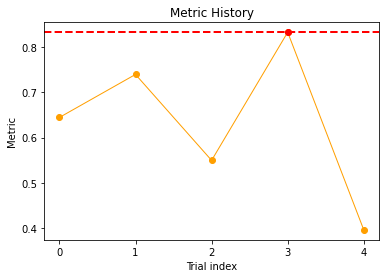

100%|██████████| 5/5 [5:07:01<00:00, 3684.36s/trial, best loss: -0.8320011418783899]
HPARAMETER SEARCH FINISHED.


In [12]:
delete_file('trials_sklearn')

model = sklearn_model.SklearnModel1(minimize_metric = False)

res = model.search(data, crf_params.search_space, crf_params.search_fixed, num_iter = 5)
best_hparams = res['best_params']
best_hparams.update(crf_params.search_fixed)

In [13]:
model = sklearn_model.SklearnModel1(minimize_metric = False, **best_hparams)
res = model.fit(data)

res

sklearn_model hparameters: {'algorithm': 'lbfgs', 'all_possible_states': True, 'all_possible_transitions': True, 'c1': 225.53458206188282, 'c2': 0.0035686049585393607, 'delta': 0.0017547519996294854, 'epsilon': 0.3450664281554772, 'linesearch': 'StrongBacktracking', 'max_linesearch': 21, 'min_freq': 4, 'num_memories': 10, 'period': 7}
X_train generator repeat: 1
X_train generator repeat: 2
X_train generator repeat: 3
X_train generator repeat: 4
C:\projects\env\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


{'metric': 0.8306922733363109}

In [14]:
model.save()

In [22]:
def get_doc_text(doc_id):
    doc = load_train_example_by_name(doc_id)
    doc_tokens = preprocess_tokenize_doc(doc)
    return ' '.join(doc_tokens)# TODO: unlazy

In [20]:
test_preds = []
ids = []
for doc_id in val_idx[:5]:
    
    # Load and preprocess
    doc = load_train_example_by_name(doc_id)
    doc_tokens = preprocess_tokenize_doc(doc)

    # Extract features
    x = {'output': pd.DataFrame({'TOKEN': doc_tokens})}
    x = feature_extractor.transform(x)

    # Predict
    pred = model.predict([x])
    pred = pred[0]['output'][0]
    pred = np.array([int(p) for p in pred])

    # Token idx
    pos_pred_idx = [i[0] for i in np.argwhere(pred == 1)]
    pred_delimited = []
    if len(pred > 0):
        pred_prev = pos_pred_idx[0]
        for p in pos_pred_idx:
            if p - pred_prev > 3:
                pred_delimited.append(-1)
            
            pred_delimited.append(p)
            pred_prev = p

    # Get corresponding tokens
    pred_tokens = [('|' if i == -1 else doc_tokens[i]) for i in pred_delimited]
    
    pred_joined = ' '.join(pred_tokens)
    pred_tokens = pred_joined.split(' | ')
    preds_joined = list(set(pred_tokens))

    preds_joined_cleaned = preds_joined#[]

    """for p in preds_joined:
        label_similarities = [fuzz.ratio(l, p) for l in labels]
        if max(label_similarities) >= 70:
            preds_joined_cleaned.append(labels[np.argmax(label_similarities)])"""
        
    # 2 options: remove if not similar to any label, or keep without modification

    preds_joined_cleaned = list(set(preds_joined_cleaned))
    test_preds.append('|'.join(preds_joined_cleaned))
    ids.append(doc_id)

sub_df = pd.DataFrame(columns = ['Id', 'PredictionString'])
sub_df['Id'] = ids
sub_df['PredictionString'] = test_preds

In [31]:
pd.options.display.max_rows = 25
pd.options.display.max_colwidth = 150
sub_df

,Id,PredictionString
0,7a9fcb80-85b1-47bb-a3a5-4069c69b4068,adni
1,d6bce360-e056-42ba-9b18-e687407f1661,early childhood longitudinal study
2,09f36a02-f4d1-4fb3-840c-5c7a2285b17c,blsa baltimore longitudinal study of aging
3,9e08d7d3-8f8c-4b0a-9445-f9cfba0813b7,kansas farm management association|agricultural resource management survey|agricultural resource management survey arms data for survey
4,e657b6c3-e32c-4daf-a092-3de500980f37,adni


In [40]:
str_find = 'adni'
doc_id = '	9e08d7d3-8f8c-4b0a-9445-f9cfba0813b7	'.strip()
text = get_doc_text(doc_id)

str_i = text.index(str_find)
text[str_i - 100:str_i + 100 + len(str_find)]

'ised in accordance with criteria used in the japanese alzheimer s disease neuroimaging initiative j adni project 29 30 where mci was defined as amnestic mci as originally presented by petersen et al 31 me'

In [41]:
text[:200]

'a third of dementia cases could be attributable to modifiable risk factors midlife high density lipoprotein cholesterol hdl c is a measure which could help identify individuals at reduced risk of deve'

In [45]:
load_train_example_by_name('e657b6c3-e32c-4daf-a092-3de500980f37'.strip())

ed with dementia at the time of screening, leaving 1114 participants of which 651 participants had complete information on all variables. For the purpose of dementia analyses, 386 persons with confirmed MCI were excluded, thereby leaving 781 participants for analyses of which 455 participants had complete information on all variables.\nSurveys of JPHC study participants were conducted on three occasions and included detailed questionnaires with information on socioeconomic and lifestyle factors. The present study used information from the baseline (1990) and 5-year follow-up survey (1995).\nAll participants provided written informed consent to take part in the mental health screening in 2014-2015, and the study has been approved by the Institutional Review Board of the National Cancer Center (approval number: 2013-096).'},
 {'section_title': 'Serum lipids',
  'text': "The details on obtaining participants' lipids have been previously described. 21 In brief, information was available fo